In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [ ]:
import pathlib
dataset_url = "https://mo.columbari.us/static/images.tgz"
data_dir = tf.keras.utils.get_file('', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

500


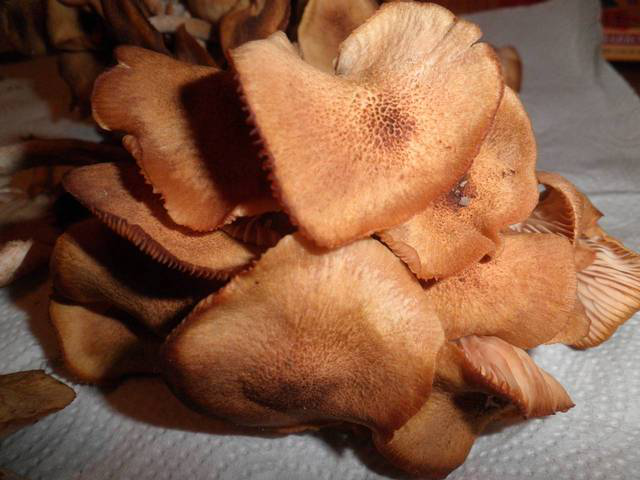

In [ ]:
armillaria_tabescens = list(data_dir.glob('armillaria_tabescens/*'))
PIL.Image.open(str(armillaria_tabescens[0]))

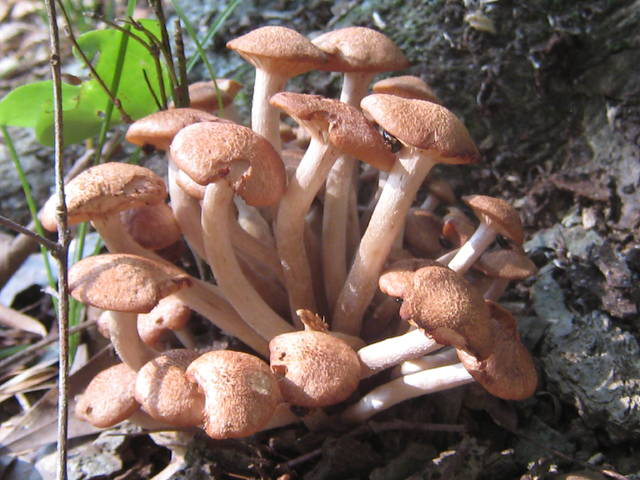

In [ ]:
PIL.Image.open(str(armillaria_tabescens[1]))

load parameters:

In [ ]:
batch_size = 32
img_height = 500
img_width = 375

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 36 classes.
Using 50 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['agaricus_hondensis', 'amanita_volvata', 'armillaria_tabescens', 'ascocoryne_cylichnium', 'auriscalpium_andinum', 'biatora_chrysantha', 'bisporella_resinicola', 'butyriboletus_floridanus', 'chlorosplenium_chlora', 'colpoma_crispum', 'cortinarius_burlinghamiae', 'ductifera_pululahuana', 'exidiopsis_calcea', 'flammulaster_muricatus', 'gamundia_striatula', 'ganoderma_testaceum', 'gloeophyllum', 'hygrophorus_persoonii', 'hypocreopsis_rhododendri', 'hypogymnia_duplicata', 'hypogymnia_schizidiata', 'lachnellula_calyciformis', 'lentinellus_cochleatus', 'leptogium_corticola', 'leptoporus_mollis', 'lobariella_reticulata', 'muellerella_lichenicola', 'peltula_euploca', 'phaeotremella_foliacea', 'pholiota_chocenensis', 'pholiota_tuberculosa', 'pluteus_longistriatus', 'rhizomarasmius_pyrrhocephalus', 'russula_modesta', 'thamnolia_subuliformis', 'tuber_oligospermum']


## Visualize the data

first 9 images from the training dataset:

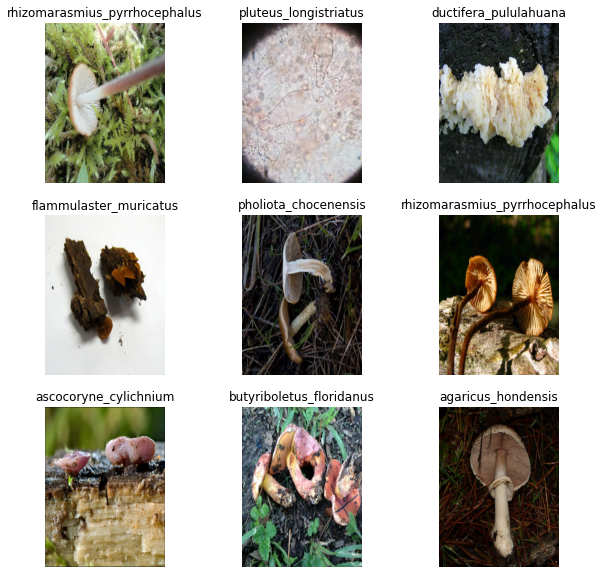

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 500, 375, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.10051952 0.9915769


In [ ]:
num_classes = 36

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 500, 375, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 500, 375, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 250, 187, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 250, 187, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 125, 93, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 93, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 46, 64)       

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 500, 375, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 500, 375, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 500, 375, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 250, 187, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 250, 187, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 125, 93, 32)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 125, 93, 64)      

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
15/15 [==============================] - 2s 111ms/step - loss: 5.8220 - accuracy: 0.0263 - val_loss: 3.6732 - val_accuracy: 0.0000e+00
Epoch 2/15
15/15 [==============================] - 2s 100ms/step - loss: 3.5053 - accuracy: 0.0322 - val_loss: 3.5236 - val_accuracy: 0.0200
Epoch 3/15
15/15 [==============================] - 2s 101ms/step - loss: 3.3237 - accuracy: 0.0534 - val_loss: 3.5069 - val_accuracy: 0.0200
Epoch 4/15
15/15 [==============================] - 2s 101ms/step - loss: 3.1820 - accuracy: 0.1119 - val_loss: 3.3964 - val_accuracy: 0.0800
Epoch 5/15
15/15 [==============================] - 2s 107ms/step - loss: 3.0339 - accuracy: 0.1736 - val_loss: 3.2074 - val_accuracy: 0.1000
Epoch 6/15
15/15 [==============================] - 2s 101ms/step - loss: 2.9589 - accuracy: 0.1666 - val_loss: 3.2608 - val_accuracy: 0.1400
Epoch 7/15
15/15 [==============================] - 2s 102ms/step - loss: 2.9569 - accuracy: 0.1737 - val_loss: 3.2303 - val_accuracy: 0.1400
Ep

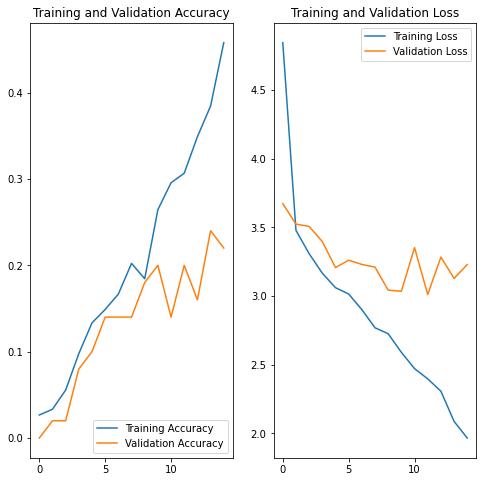

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict

In [ ]:
tabescens_url = "https://www.mushroomexpert.com/images/kuo6/armillaria_tabescens_06.jpg"
tabescens_path = tf.keras.utils.get_file('armillaria_tabescens_06', origin=tabescens_url)

img = keras.preprocessing.image.load_img(
    tabescens_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

90112/85752 [===============================] - 0s 1us/step
This image most likely belongs to armillaria_tabescens with a 51.50 percent confidence.
